# Lab 4 : Non-negative Matrix Factorization

The goal of this lab session is to code a NMF algorithm and use it in some applications.

You have to send the filled notebook named **"NMF_familyname1_familyname2.ipynb"** (groups of 2) by email to *lucca.guardiola@centralesupelec.fr* by November 12, 2020 and put **"AML-NMF"** in the subject. 

We begin with the standard imports:

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

# NMF - Recap

Non-negative Matrix Factorization is a model where a matrix X is factorized into two matrices W and H, with the property that all three matrices have no negative elements. This non-negativity makes the resulting matrices easier to interpret.


Loss (Regularized Froebnius): $\mathcal{L}(W, H) = \frac{1}{2}\|X-W H\|_{F}^{2}+ \color{red}{\frac{\mu}{2}\|H\|_{F}^{2}+\lambda\|H\|_{1}+\frac{\nu}{2}\|W\|_{F}^{2}}$

Algorithm (multiplicative updates from [Lee and Seung, 1999] (http://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf)

\begin{array}{c}
W \leftarrow W .* \left(X H^T\right)./W \left(H H^{\top} + {\color{red} \nu I_r}\right) \\
H \leftarrow H .* \left(W^{\top} X - {\color{red} \lambda 1_{r \times n}}\right)./\left((W^{\top} W + {\color{red} \mu I_r})H\right)
\end{array}


.* is the dot product ( in python  : A*B ) 

AB is the matrix product ( in python : A@B )

## Initialization 

The computation time and the convergence of the NMF depends on how you initialize the matrices W and H.
You will implement and compare two types of initialization. 

#### Random initialization : 

$\forall i,j, H^0_{i,j}\sim U_{[0,1]}$ and $ W^0_{i,j}\sim U_{[0,1]} $

Each term of $W^0$ and $H^0$ is sampled with a uniform distribution. Use np.random.random(Matrix_shape)

#### NNDSVD initialization : 

Singular value decomposition (SVD) is a classical method that extends the eigen-decomposition to non-square matrix.

For any $ X \in \mathbb{R}^{N\times M}$, there exists a factorization with the following form:

$$ X = U \Sigma V^T $$

With $ U \in \mathbb{R}^{N\times N} , \Sigma  \in \mathbb{R}^{N\times M} \text{ such as } \Sigma = \begin{pmatrix} 
\Sigma_1 & 0 \\
0 & 0 
\end{pmatrix} , V \in \mathbb{R}^{M\times M} $



$\Sigma_1 = diag(σ1, σ2, ..., σr)$, and the diagonal entries are sorted in descending order, i.e. σ1 ≥ σ2 ≥ ... ≥ σr > 0,
σi, i = 1, 2, ...r being the singular values with r = rank(Z)


After the computation of the SVD of X, the initialization of W and H is made with  

$$ W^0 = |U_{:,:r}|$$
$$ H^0 = | \Sigma_{:r,:}V^T| $$ 
$|.|$ means the absolute value for each term of the matrix, r = number of components of the NMF :

You will need : 
np.linalg.svd 

Watch out np.linalg.svd returns only the diagonal of $\Sigma$. I advise you ton create a empty matrix $\Sigma$ with np.zeros(Shape of the matrix) then fill the diagonal with np.diag(). You can use the exemple in https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html



### Tasks  :  
- Fill the fit transform function. Consider $\mathcal{L}(W, H) = \frac{1}{2}\|X-W H\|_{F}^{2}$ (no regularization)
- Implement NNSVD initialization and random initialization. 
- Return W H and the Froebenius norm of the residuals (the loss) when the convergence condition is fulfilled.

(This should take you less than 30 minutes)

In [57]:
class my_NMF():
    
    def __init__(self, n_components, epsilon,init, max_iter = 60):
        '''
        Attributes:
        
        n_components_ : integer
            the unknown dimension of W and H
        max_iter_: integer
            maximum number of iterations
        epsilon_ : float
        init_ :  {"random", "NNDSVD"}
        w_: np.array
            W Matrix factor
        H_: np.array
            H Matrix factor
        '''
        self.n_components = n_components
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.init = init
        self.W = None
        self.H = None
        
        
    def fit_transform(self, X):
        """ Find the factor matrices W and H
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        W,H,loss
        """        
        n,p = X.shape
        if self.init == 'NNDSVD' : 
            
            u, s, vh = np.linalg.svd(X)
            W_0=np.abs(u[:,:self.n_components])
            smat = np.zeros((u.shape[0], vh.shape[0]))
            smat[:u.shape[0], :u.shape[0]] = np.diag(s)
            H_0 = smat[:self.n_components,:]@vh
            
            
        elif self.init == 'random' :
            W_0 = np.random.random((n,self.n_components))
            H_0 = np.random.random((self.n_components,p))
            
            
            
            
        convergence = False 
        nb_iter = 0
        H=H_0
        W=W_0
        while not(convergence) : 
            WH = np.dot(W,H)
            
            #The convergence is reached when the number of iteration is equal to self.max_iter or
            #when the loss < self.epsilon
            loss= 1/2*((np.linalg.norm(X-WH))**2)
            if (loss < self.epsilon) :
                convergence = True
            else :
                if (nb_iter>= self.max_iter):
                    convergence = True
                else:
                    nb_iter+=1
                    W=(W*(X@(H.T)))/(W@(H@(H.T)))
                    H=(H*((W.T)@X))/(((W.T)@W)@H)
        
        self.W = W
        self.H = H
                
        return W,H,loss


### Bonus : Implement the regularized version

## Applications

### First application - Images

For the first application you are going to analyse the following data to give an interpretation of the factorization:

[[0.6694215  0.6363636  0.6487603  ... 0.08677686 0.08264463 0.07438017]
 [0.76859504 0.75619835 0.74380165 ... 0.48347107 0.6280992  0.6528926 ]
 [0.37190083 0.34710744 0.3677686  ... 0.7066116  0.6818182  0.5495868 ]
 ...
 [0.55785125 0.60330576 0.6570248  ... 0.17768595 0.20661157 0.19421488]
 [0.5206612  0.5206612  0.53305787 ... 0.46694216 0.43801653 0.43801653]
 [0.3966942  0.3677686  0.3429752  ... 0.37190083 0.26859504 0.29752067]]


(400, 4096)

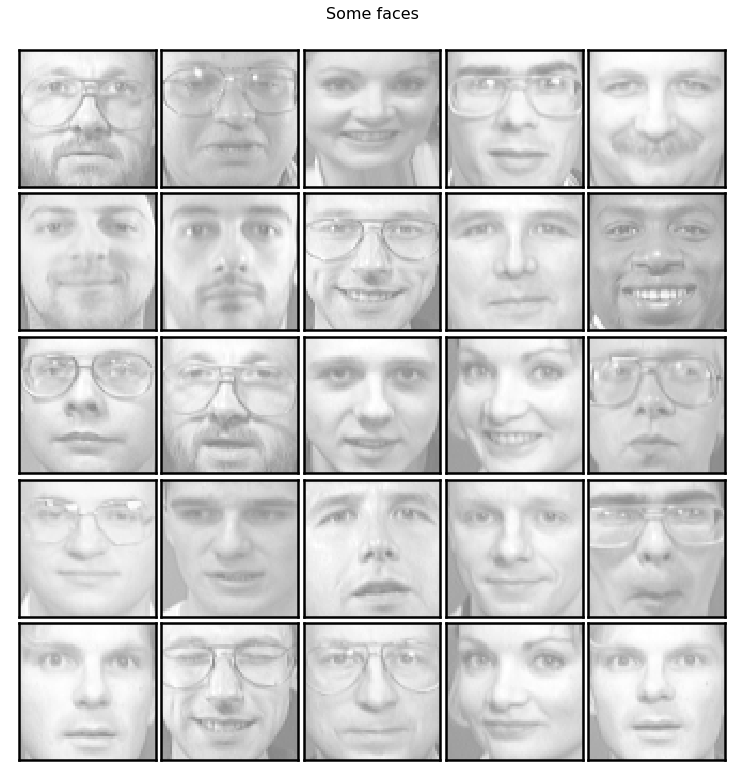

In [58]:
from sklearn.datasets import fetch_olivetti_faces

dataset = fetch_olivetti_faces(shuffle=True)

faces = dataset.data
image_shape = (64, 64)
print(faces)

n_samples, n_features = faces.shape

def plot_faces(title, images, image_shape, n_col=5, n_row=5, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    
plot_faces("Some faces", faces[:25], image_shape)

faces.shape

### Task : apply your NMF algorithm to this dataset and plot the approximated face pictures. Compare the different initializations

(25, 4096)
(400, 150)
(150, 4096)


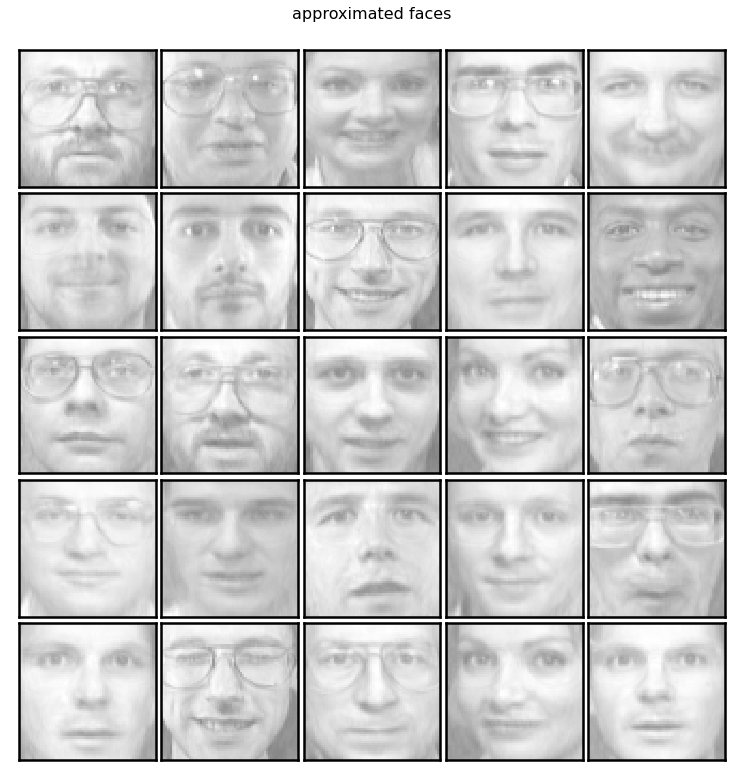

In [59]:
# TODO 

NMF=my_NMF(n_components=150, epsilon=0.1, init='NNDSVD')
W,H,loss = NMF.fit_transform(faces)
#print(W,H,"loss ============== ", loss)

faces_appro = W@H
plot_faces("approximated faces", faces_appro[:25], image_shape)

print(faces[:25].shape)
print(W.shape)
print(H.shape)

### Tasks :  
- Apply NMF with the SVD initialisation and with a number of components r such as $\sqrt r$ is an integer (r = 4,16,etc..) 
- Plot the $H$ matrix as images in a $(\sqrt{r}, \sqrt{r})$ grid ( n_col=n_row=$\sqrt r $)
- Choose one face, plot its corresponding weights (in $W$) in a grid 
- How can we interpret the matrices H and W.

Be careful with the arguments image_shape, n_col n_row in the plot_faces function

(64,)
(400, 4096)
(400, 64)
(64, 4096)


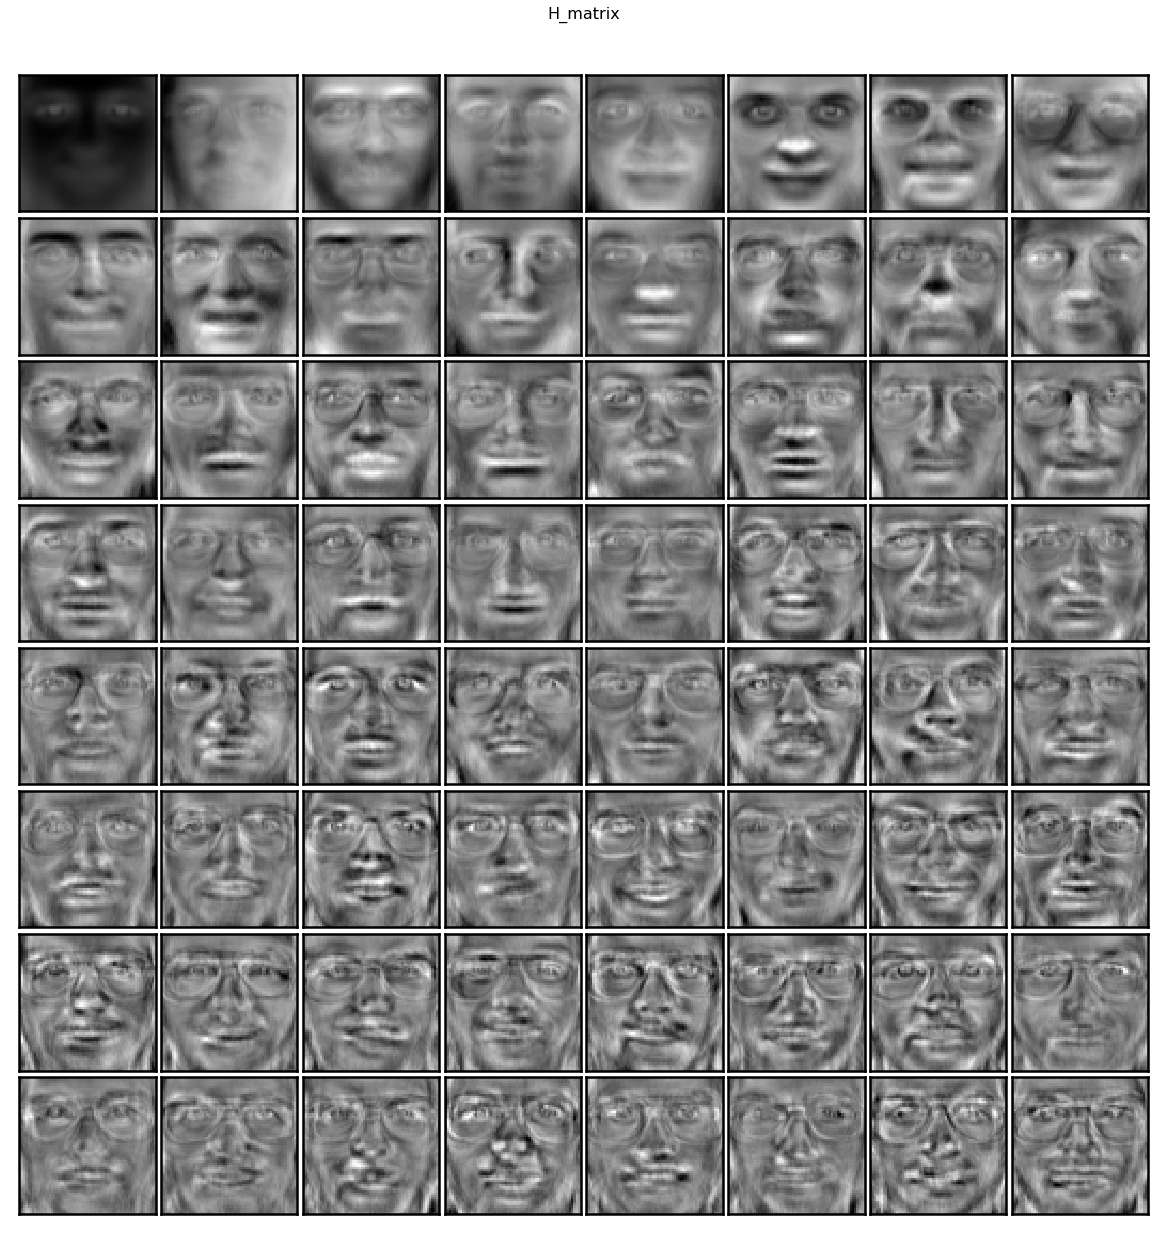

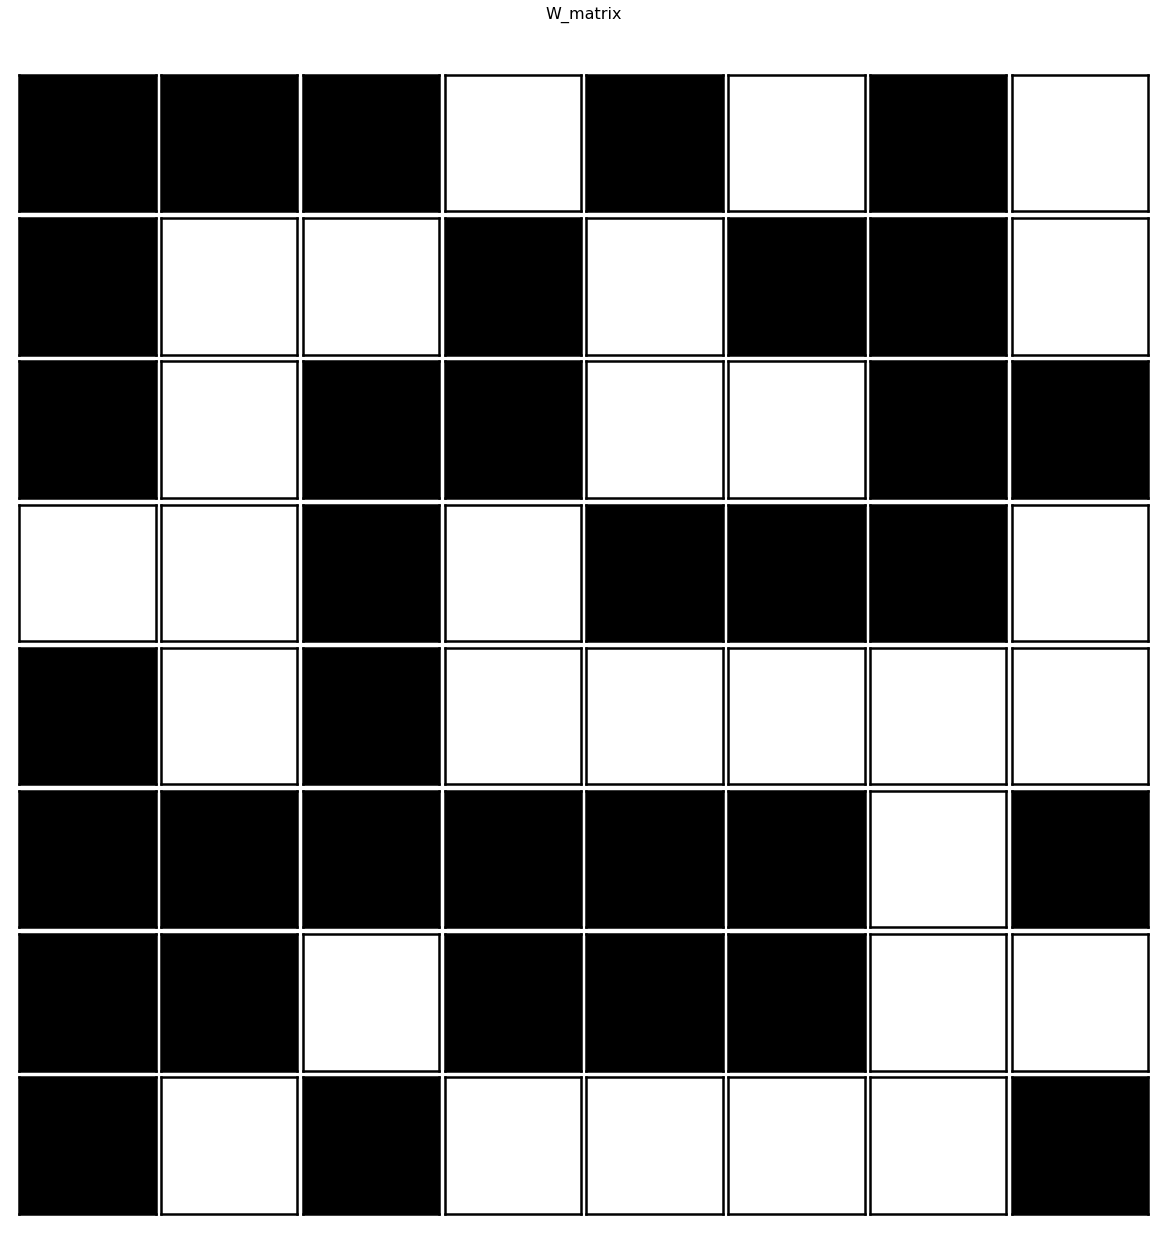

In [7]:
NMF=my_NMF(n_components=64, epsilon=0.1, init='NNDSVD')
W,H,loss = NMF.fit_transform(faces)
#print(W,H,"loss ============== ", loss)

print(W[99,:].shape)
faces_appro = W@H
plot_faces("H_matrix", H, image_shape, n_col=8, n_row=8)

# We plot here the weight of the face 99 (there is 400 faces)
W_shape=(1,1)
plot_faces("W_matrix", W[99,:], W_shape, n_col=8, n_row=8)

print(faces.shape)
print(W.shape)
print(H.shape)

# All the components of W can be seen as the latent features  and those in H as the coordinates of each data point in the
# factor matix W

### Second application

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 news documents from 20 different newsgroups (i.e 20 different topics like art news, geopolitical news etc...)

The goal of this exercice is to model the topics present with NMF then print the most common words of each topic.

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups

n_samples = 5000
n_features = 2000
n_components = 10
n_top_words = 20

def print_top_words(D, feature_names, n_top_words):
    p, r = D.shape
    for topic_idx in range(r):
        topic = D[:, topic_idx]
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))

data_samples = dataset.data[:n_samples]


print(data_samples[:3]) # A few exemple of news 

["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n", "\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap 

### Feature extraction/engineering 

Before applying NMF, you have to convert text into numerical values in order to vectorize your documents.

We will be looking at the Count vectorizer method and the TF-IDF vectorizer.

### Count vectorizer. 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

We define a corpus by an ensemble of documents $(D_1,...D_N)$. From this corpus we collect all the different words used in the documents, this collection of words $(w_1,...w_p)$ is called the vocabulary of the corpus.

Using the count vectorizer, the numerical representation of a document $D_i$ will be Count_Vectoriser$(D_i) = \sum_{j=1}^p f_{ij}w_j $ With f_ij, the frequency of appearence of the word $w_j$ in the document $i$.

### TF-IDF

Task : Search for TF-IDF. Explain its principle and its difference with count_vectorizer

Answer :  Given a collection of documents that make up a corpus, tf-idf assigns scores to words in each document which represents how important the word is in describing the document. 'Generally', the more important the word, the higher it's tf-idf score. The score is a product of two distinct terms TF (term frequency - how often the word occurs in the document) and IDF (Inverse Document Frequency - is a weighting factor that values rare words. It is constant for each word in the corpus and is a measure of how rare the word is in the corpus.)


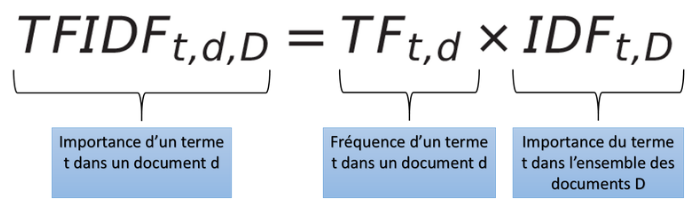



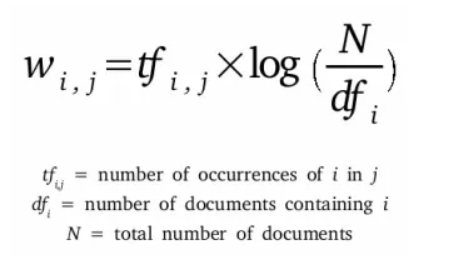

So TF-IDF take into account both the frequency of the word in documents and in the corpus. CountVectorizer take only the frequency documents

### Task : Vectorize your document with Count Vectorizer or TF-IDF. 
#### Put in argument stop_words='english'  and max_features=n_features 
Stop_words is a list of common words that don't bring any information like 'the', 'a' etc... We don't want these words to take up space in our database for computation time reason and because they could harm the numerical representation of the documents. 

You must obtain a $5000\times2000$ shaped matrix 

In [61]:
vectorizer_count = CountVectorizer(stop_words='english', max_features=n_features)
vec_sample = vectorizer.fit_transform(data_samples)

vectorizer_tfidf=TfidfVectorizer(stop_words='english', max_features=n_features)
vec_sample_tfidf=vectorizer_tfidf.fit_transform(data_samples)

print(vec_sample.shape)
print(vec_sample_tfidf.shape)

(5000, 2000)
(5000, 2000)



### Task : Apply NMF from sklearn with a choosen initialization. Then print the top words for each topics with print_top_words

Use tfidf_vectorizer.get_feature_names() to recover the words. 

In [62]:
from sklearn.decomposition import NMF

In [63]:

model = NMF(n_components=20, init='nndsvd', tol=0.1, max_iter=200)

W = model.fit_transform(vec_sample_tfidf)
H = model.components_

print(H.shape)
print(W.shape)
print(W)
print_top_words(H.T, vectorizer.get_feature_names(), n_top_words)

(20, 2000)
(5000, 20)
[[0.01038462 0.         0.00041612 ... 0.01723871 0.02318812 0.00117077]
 [0.01956099 0.00320711 0.02634297 ... 0.         0.         0.0142752 ]
 [0.         0.         0.         ... 0.         0.01681791 0.0590515 ]
 ...
 [0.00323123 0.         0.1277343  ... 0.00374473 0.02374565 0.00725647]
 [0.0009812  0.         0.         ... 0.09803942 0.         0.06726354]
 [0.03465526 0.         0.         ... 0.01407718 0.02327571 0.        ]]
Topic #0: people don good time right say make ll did really way going course believe years point want gun said think
Topic #1: thanks advance mail card hi looking help software pc video mac need appreciated info graphics board email hello color monitor
Topic #2: god jesus bible faith christians christ christian believe church lord heaven love life father son people sin say true belief
Topic #3: key chip encryption clipper keys government use law escrow public enforcement security data nsa phone algorithm encrypted secure bit pri

The relevance of the topics can be improved with better parameters in the vectorizer, a more advanced cleaning in addition to the stopwords (for instance getting rid of the numbers etc ...) or more advanced vectorizer/encoder like Word2Vec or Doc2Vec which use very simple neural networks. 

### Imagine we would like to gather the news coming from the same newsgroup/news category. How would you do using the NMF and the previous courses ? 

Answer : 
The matrix W of the NMF is a representation of each individual in another, smaller, base. Each individuals would have different weights. If two indivuduals have almost the same weights, in a given basis (for a given H), it means their are quite similar, so they belong to the same group. 

Our idea here would be to find the smallest 

### Implement your solution.

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
from sklearn.cluster import KMeans


def plot_inertia(k_min,k_max,data):
    """ Fit several kmeans models with different K in order to find visually the optimal K with the elbow method 

    Output : 
    plot the inertia as a function of the number of clusters
    """
    inertia = []
    for k in range(k_min,k_max):
        kmeans = KMeans(n_clusters=k).fit(data)
        inertia.append(kmeans.inertia_)   
        
        
    plt.plot([k for k in range(k_min,k_max)],inertia)

  


In [113]:
  
data=[]
for i in range (4,6):
    n_comp=i*5
    model = NMF(n_components=n_comp, init='nndsvd', tol=0.1, max_iter=200)
    W = model.fit_transform(vec_sample_tfidf)
    data.append(W)



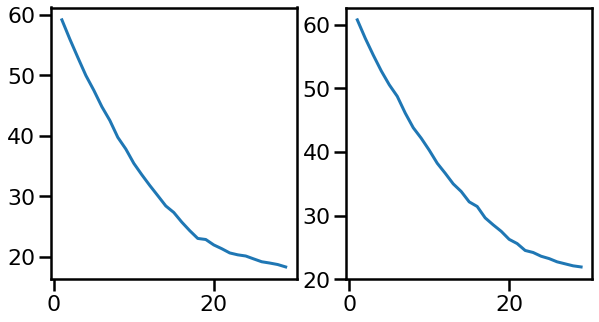

In [115]:
plt.figure(figsize=(15, 5))
for i in range (len(data)):
    plt.subplot(1, 3, i+1)
    plot_inertia(1,30,data[i])

In [116]:
#We can see that after n_components=20 , the elbow remains around 20, so we can use an NMF with n_components=20 and apply
# a kmean algorithm on the W matrix. 

''